## Классификация новостей [AG's News Topic Classification Dataset](https://github.com/mhjabreel/CharCnn_Keras/tree/master/data/ag_news_csv)

Используется три архитектуры нейронных сетей:
- Одномерная сверточная нейросеть
- Рекуррентная нейросеть LSTM
- Рекуррентная нейросеть GRU

Для ускорения обучения сети рекомендуется подключить GPU (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU).

In [76]:
import re
import os
import nltk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [77]:
# Enable to see which operations are assigned to the GPU
tf.debugging.set_log_device_placement(True)  # Set to True for detailed logs

# Confirm GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [78]:
# Максимальное количество уникальных слов слов
num_words = 10000
# Максимальная длина новости
max_news_len = 30
# Количество классов новостей
nb_classes = 4

## Загрузка набора данных

Загружаем данные для обучения

In [79]:
!wget https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv -O train.csv

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
--2025-12-01 19:12:39--  https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv [following]
--2025-12-01 19:12:39--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29470338 (28M) [text/plain]
Saving to: 'train.csv'

train.csv           100%[===================>]  28.10M  5.55MB/s    in 5.0s    

2025-1

Загружаем данные для тестирования

In [80]:
!wget https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv -O test.csv

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
--2025-12-01 19:12:46--  https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv [following]
--2025-12-01 19:12:46--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1857427 (1.8M) [text/plain]
Saving to: 'test.csv'

test.csv            100%[===================>]   1.77M  1.72MB/s    in 1.0s    

2025-12-01

Загружаем имена классов

In [81]:
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt -O classes.txt

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
--2025-12-01 19:12:48--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31 [text/plain]
Saving to: 'classes.txt'

classes.txt         100%[===================>]      31  --.-KB/s    in 0s      

2025-12-01 19:12:49 (3.07 MB/s) - 'classes.txt' saved [31/31]



## Просматриваем данные

In [82]:
!ls

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
classes.txt  lab_4_ktuner.ipynb   lab_4_manual.ipynb	test.csv   wget-log
lab_3.ipynb  lab_4_ktuner2.ipynb  nlp_class_news.ipynb	train.csv


In [83]:
!cat classes.txt

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
World
Sports
Business
Sci/Tech


In [84]:
!head train.csv

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
"3","Wall St. Bears Claw Back Into the Black (Reuters)","Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
"3","Carlyle Looks Toward Commercial Aerospace (Reuters)","Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
"3","Oil and Economy Cloud Stocks' Outlook (Reuters)","Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums."
"3","Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)","Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Sat

In [85]:
!head test.csv

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
"3","Fears for T N pension after talks","Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."
"4","The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com)","SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket."
"4","Ky. Company Wins Grant to Study Peptides (AP)","AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins."
"4","Prediction Unit Helps Forecast Wildfires (AP)","AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and e

In [86]:
!wc -l train.csv
!wc -l test.csv

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
120000 train.csv
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
7600 test.csv


## Загружаем данные в память

Читаем данные из файла

In [87]:
train = pd.read_csv('train.csv',
                    header=None,
                    names=['class', 'title', 'text'])

In [88]:
train

,class,title,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
1,3,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
3,3,Iraq Halts Oil Exports from Main Southern Pipeline (Reuters),"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday."
4,3,"Oil prices soar to all-time record, posing new menace to US economy (AFP)","AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army Chief,"KARACHI (Reuters) - Pakistani President Pervez Musharraf has said he will stay on as army chief, reneging on a pledge to quit the powerful post by the end of the year."
119996,2,Renteria signing a top-shelf deal,"Red Sox general manager Theo Epstein acknowledged Edgar Renteria was more a luxury for the 2005 Red Sox than a necessity. But there's nothing wrong with getting the keys to a BMW, and that's what the four-time All-Star and two-time Gold Glover is in the eyes of the Red Sox."
119997,2,Saban not going to Dolphins yet,"The Miami Dolphins will put their courtship of LSU coach Nick Saban on hold to comply with the NFL's hiring policy by interviewing at least one minority candidate, a team source told The Associated Press last night."
119998,2,Today's NFL games,"PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: Steelers by 10. Records: Steelers 12-1, Giants 5-8. Vs. spread: Steelers 10-1-2, Giants 5-8. Series: Giants lead, 43-27-3. Comments: Think the Giants knew Ben Roethlisberger was available on draft day when they broke the bank and traded for Eli Manning? . . . All Big Ben has done this year is complete ..."


Выделяем данные для обучения

In [89]:
news = train['text']
# news = train['title'] + ' ' + train['text']

In [90]:
news[:5]

0                                                                                                                            Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
1    Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
2                                  Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
3                       Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.
4                                                          AFP - Tearaway world oil prices, toppling records and straini

Выделяем правильные ответы

In [91]:
# Преобразование целочисленного вектора класса в двоичную матрицу
# Аргументы: вектор классов в данных и общее количество классов
y_train = utils.to_categorical(train['class'] - 1, nb_classes)

In [92]:
y_train

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], shape=(120000, 4))

## Токенизация текста

In [93]:
news[:5]

0                                                                                                                            Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
1    Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
2                                  Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
3                       Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.
4                                                          AFP - Tearaway world oil prices, toppling records and straini

Создаем токенизатор Keras

<img src="https://habrastorage.org/r/w1560/getpro/habr/upload_files/bc9/feb/314/bc9feb3143af4759aceff629305cf8ae.png">

Принцип работы модуля TextVectorization

In [94]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=num_words,
    output_mode='int',
    output_sequence_length=max_news_len)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op HashTableV2 in device /job:localhost/replica:0/task:0/device:CPU:0
k:0/device:CPU:0
Reshape: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
TensorSliceDataset: (TensorSliceDataset): /job:localhost/replica:0/task:0/device:CPU:0
Slice_1: (Slice): /job:localhost/replica:0/task:0/device:CPU:0
TensorDataset: (TensorDataset): /job:localhost/replica:0/task:0/device:CPU:0
ConcatenateDataset: (ConcatenateDataset): /job:localhost/replica:0/task:0/device:CPU:0
NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Slice/begin: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Slice/size: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Reshape/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Slice_1/begin: (Const): /job:localhost/repl

2025-12-01 19:12:50.161078: I tensorflow/core/common_runtime/placer.cc:162] table__handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:12:50.161120: I tensorflow/core/common_runtime/placer.cc:162] HashTableV2: (HashTableV2): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:12:50.163504: I tensorflow/core/common_runtime/placer.cc:162] table__handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:12:50.163529: I tensorflow/core/common_runtime/placer.cc:162] MutableHashTableV2: (MutableHashTableV2): /job:localhost/replica:0/task:0/device:CPU:0


In [95]:
vectorize_layer.adapt(news)
vectorize_layer.get_vocabulary()

Executing op LookupTableExportV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LookupTableRemoveV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ExpandDims in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringLower in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StaticRegexReplace in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Squeeze in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StringSplitV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Strided

2025-12-01 19:12:51.009078: I tensorflow/core/common_runtime/placer.cc:162] table__handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:12:51.009117: I tensorflow/core/common_runtime/placer.cc:162] HashTableV2: (HashTableV2): /job:localhost/replica:0/task:0/device:CPU:0


['',
 '[UNK]',
 np.str_('the'),
 np.str_('a'),
 np.str_('to'),
 np.str_('of'),
 np.str_('in'),
 np.str_('and'),
 np.str_('on'),
 np.str_('for'),
 np.str_('that'),
 np.str_('39s'),
 np.str_('with'),
 np.str_('as'),
 np.str_('its'),
 np.str_('at'),
 np.str_('is'),
 np.str_('said'),
 np.str_('by'),
 np.str_('it'),
 np.str_('has'),
 np.str_('new'),
 np.str_('an'),
 np.str_('from'),
 np.str_('his'),
 np.str_('us'),
 np.str_('will'),
 np.str_('was'),
 np.str_('reuters'),
 np.str_('after'),
 np.str_('have'),
 np.str_('be'),
 np.str_('their'),
 np.str_('are'),
 np.str_('over'),
 np.str_('ap'),
 np.str_('he'),
 np.str_('but'),
 np.str_('two'),
 np.str_('first'),
 np.str_('this'),
 np.str_('more'),
 np.str_('monday'),
 np.str_('wednesday'),
 np.str_('tuesday'),
 np.str_('thursday'),
 np.str_('company'),
 np.str_('up'),
 np.str_('friday'),
 np.str_('inc'),
 np.str_('one'),
 np.str_('world'),
 np.str_('yesterday'),
 np.str_('they'),
 np.str_('last'),
 np.str_('york'),
 np.str_('against'),
 np.str_

In [96]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на новостях

In [97]:
tokenizer.fit_on_texts(news)

Просматриваем словарь токенизатора

In [98]:
tokenizer.word_index

{'the': 1,
 'a': 2,
 'to': 3,
 'of': 4,
 'in': 5,
 'and': 6,
 'on': 7,
 'for': 8,
 '39': 9,
 's': 10,
 'that': 11,
 'with': 12,
 'as': 13,
 'its': 14,
 'at': 15,
 'said': 16,
 'is': 17,
 'by': 18,
 'it': 19,
 'has': 20,
 'new': 21,
 'an': 22,
 'from': 23,
 'reuters': 24,
 'his': 25,
 'will': 26,
 'was': 27,
 'after': 28,
 'have': 29,
 'be': 30,
 'their': 31,
 'two': 32,
 'are': 33,
 'us': 34,
 'over': 35,
 'quot': 36,
 'year': 37,
 'first': 38,
 'ap': 39,
 'he': 40,
 'but': 41,
 'gt': 42,
 'lt': 43,
 'this': 44,
 'more': 45,
 'monday': 46,
 'wednesday': 47,
 'one': 48,
 'tuesday': 49,
 'up': 50,
 'thursday': 51,
 'company': 52,
 'inc': 53,
 'friday': 54,
 'world': 55,
 'than': 56,
 'u': 57,
 '1': 58,
 'last': 59,
 'they': 60,
 'york': 61,
 'yesterday': 62,
 'against': 63,
 'about': 64,
 'who': 65,
 'not': 66,
 'were': 67,
 'into': 68,
 'out': 69,
 'three': 70,
 'been': 71,
 'president': 72,
 '2': 73,
 'had': 74,
 'million': 75,
 'corp': 76,
 'oil': 77,
 'when': 78,
 'week': 79,
 'time'

Преобразуем новости в числовое представление

In [99]:
sequences = tokenizer.texts_to_sequences(news)

Просматриваем новости в числовом представлении

In [100]:
index = 1
print(news[index])
print(sequences[index])

Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
[24, 863, 751, 371, 93, 84, 20, 2, 3916, 8, 453, 431, 6, 1308, 2799, 5, 1, 549, 237, 20, 3528, 2002, 14, 8267, 7, 216, 314, 4, 1, 131]


In [101]:
tokenizer.word_index['reuters']

24

Ограничиваем длину текста

In [102]:
x_train = pad_sequences(sequences, maxlen=max_news_len)

In [103]:
x_train[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   24,  758, 7851,  433,
        5786, 2861,    4, 5916,   33, 3642,  831,  432],
       [  24,  863,  751,  371,   93,   84,   20,    2, 3916,    8,  453,
         431,    6, 1308, 2799,    5,    1,  549,  237,   20, 3528, 2002,
          14, 8267,    7,  216,  314,    4,    1,  131],
       [  24, 2199,  463,  105, 1568, 1484,   64,    1,  397,    6,    1,
        1026,    8,  317,   33,  178,    3, 6377,   35,    1,  311,  131,
          99,   79,  189,    1, 6120,    4,    1, 1068],
       [   0,   24,  713,   29, 5142,   77, 3549, 7993,   23,    1,  737,
        3199,    5,  493,  106,   28, 1402,  573,    2,  825, 2601,   90,
         760, 2559,   22,   77,  292,   16,    7,   97],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  165,
          55,   77,  105, 8851, 1776,    6, 8268, 3454,    2,   21,  343,
        3036,   70,  266,  151, 

## Сверточная нейронная сеть

In [104]:
model_cnn = keras.Sequential()
model_cnn.add(keras.layers.Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(keras.layers.Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(128, activation='relu'))
model_cnn.add(keras.layers.Dense(4, activation='softmax'))

/home/vad1mchk/projects/LabsDataAnalysisAndModeling/venv_tf/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [105]:
model_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:l

In [106]:
model_cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [107]:
# model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_filepath_cnn = '/tmp/ckpt/checkpoint.model_cnn.keras'
checkpoint_callback_cnn = ModelCheckpoint(checkpoint_filepath_cnn,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [108]:
history_cnn = model_cnn.fit(x_train,
                            y_train,
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Pr

2025-12-01 19:12:54.762052: I tensorflow/core/common_runtime/placer.cc:162] start: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:12:54.762095: I tensorflow/core/common_runtime/placer.cc:162] stop: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:12:54.762099: I tensorflow/core/common_runtime/placer.cc:162] step: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:12:54.762104: I tensorflow/core/common_runtime/placer.cc:162] RangeDataset: (RangeDataset): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:12:54.762106: I tensorflow/core/common_runtime/placer.cc:162] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:12:54.769296: I tensorflow/core/common_runtime/placer.cc:162] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:12:54.769336: I tensorflow/core/common_runtime/placer.cc:162] MapDataset: (MapDataset): /job:localhost/replica:0/task:0/device:CPU:0
2025

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


2025-12-01 19:12:54.916904: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:54.916947: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:54.933197: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:54.933240: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:54.943029: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:54.943075: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0


Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


2025-12-01 19:12:55.022557: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.022605: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.034919: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.034966: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.046808: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.046864: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.058923: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
ensorDataset: (TensorDataset): /job:localhost/replica:0/task:0/device:CPU:0
ConcatenateDataset: (ConcatenateDataset): /job:localhost/replica:0/task:0/device:CPU:0
NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Slice/begin: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Slice/size: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Reshape/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Slice_1/begin: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Slice_1/size: (Const): /job:localhost/replica:0/task:0/device:CPU:0
args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
args_2: (_Arg): /

2025-12-01 19:12:55.127141: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.127184: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.141448: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.141499: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.153990: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.154025: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.167873: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/

2025-12-01 19:12:55.445575: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.445626: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_1_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.445630: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_2_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.445631: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_3_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.445633: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_4_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.445634: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_5_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.445636: I tensorflow/core/common_r

b:localhost/replica:0/task:0/device:GPU:0
adam/sequential_3_embedding_3_embeddings_momentum/Initializer/zeros/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
adam/sequential_3_embedding_3_embeddings_velocity/Initializer/zeros/shape_as_tensor: (Const): /job:localhost/replica:0/task:0/device:GPU:0
adam/sequential_3_embedding_3_embeddings_velocity/Initializer/zeros/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
adam/sequential_3_conv1d_1_kernel_momentum/Initializer/zeros/shape_as_tensor: (Const): /job:localhost/replica:0/task:0/device:GPU:0
adam/sequential_3_conv1d_1_kernel_momentum/Initializer/zeros/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
adam/sequential_3_conv1d_1_kernel_velocity/Initializer/zeros/shape_as_tensor: (Const): /job:localhost/replica:0/task:0/device:GPU:0
adam/sequential_3_conv1d_1_kernel_velocity/Initializer/zeros/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
adam/sequential_3_conv1d_1_bias_momentum/Initializer/

2025-12-01 19:12:55.669969: I tensorflow/core/common_runtime/placer.cc:162] iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:12:55.670016: I tensorflow/core/common_runtime/placer.cc:162] unknown: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.670020: I tensorflow/core/common_runtime/placer.cc:162] unknown_0: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.670021: I tensorflow/core/common_runtime/placer.cc:162] unknown_1: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.670023: I tensorflow/core/common_runtime/placer.cc:162] unknown_2: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.670024: I tensorflow/core/common_runtime/placer.cc:162] unknown_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.670025: I tensorflow/core/common_runtime/placer.cc:162] unknown_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:12:55.670

Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
  1/844 ━━━━━━━━━━━━━━━━━━━━ 35:07 2s/step - accuracy: 0.1953 - loss: 1.3895Executing op __inference_multi_step_on_iterator_87802 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_87802 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_87802 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Ex

2025-12-01 19:13:07.448498: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:07.448540: I tensorflow/core/common_runtime/placer.cc:162] range: (Range): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:07.448545: I tensorflow/core/common_runtime/placer.cc:162] RandomShuffle: (RandomShuffle): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:07.448548: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:07.448550: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:07.448552: I tensorflow/core/common_runtime/placer.cc:162] range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:07.448554: I tensorflow/core/common_runtime/placer.cc:162] range/limit: (Const): /job:localhost/replica:0/task:0/device:C

Executing op __inference_multi_step_on_iterator_91452 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_91452 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_91452 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_91452 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost

2025-12-01 19:13:09.434069: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:09.434106: I tensorflow/core/common_runtime/placer.cc:162] range: (Range): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:09.434111: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:09.434112: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:09.434114: I tensorflow/core/common_runtime/placer.cc:162] range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:09.434116: I tensorflow/core/common_runtime/placer.cc:162] range/limit: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:09.434118: I tensorflow/core/common_runtime/placer.cc:162] range/delta: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-

Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
  5/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9117 - loss: 0.2653Executing op __inference_multi_step_on_iterator_87802 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_87802 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_87802 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Ex

2025-12-01 19:13:17.324029: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:17.324073: I tensorflow/core/common_runtime/placer.cc:162] range: (Range): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:17.324077: I tensorflow/core/common_runtime/placer.cc:162] RandomShuffle: (RandomShuffle): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:17.324080: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:17.324081: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:17.324083: I tensorflow/core/common_runtime/placer.cc:162] range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:17.324087: I tensorflow/core/common_runtime/placer.cc:162] range/limit: (Const): /job:localhost/replica:0/task:0/device:C

Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_91452 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_91452 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_91452 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_91452 in device /job:localhost

2025-12-01 19:13:17.910185: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:17.910229: I tensorflow/core/common_runtime/placer.cc:162] range: (Range): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:17.910246: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:17.910249: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:17.910251: I tensorflow/core/common_runtime/placer.cc:162] range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:17.910253: I tensorflow/core/common_runtime/placer.cc:162] range/limit: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:17.910255: I tensorflow/core/common_runtime/placer.cc:162] range/delta: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-

Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_87802 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
 19/844 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9330 - loss: 0.1905Executing op __inference_multi_step_on_iterator_87802 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_87802 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Exec

2025-12-01 19:13:25.388654: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:25.388699: I tensorflow/core/common_runtime/placer.cc:162] range: (Range): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:25.388703: I tensorflow/core/common_runtime/placer.cc:162] RandomShuffle: (RandomShuffle): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:25.388706: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:25.388708: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:25.388710: I tensorflow/core/common_runtime/placer.cc:162] range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:25.388713: I tensorflow/core/common_runtime/placer.cc:162] range/limit: (Const): /job:localhost/replica:0/task:0/device:C

Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_91452 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_91452 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_91452 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device

2025-12-01 19:13:25.979362: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:25.979402: I tensorflow/core/common_runtime/placer.cc:162] range: (Range): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:25.979407: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:25.979409: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:25.979411: I tensorflow/core/common_runtime/placer.cc:162] range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:25.979413: I tensorflow/core/common_runtime/placer.cc:162] range/limit: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:25.979416: I tensorflow/core/common_runtime/placer.cc:162] range/delta: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-

Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_87802 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
 13/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9581 - loss: 0.1344Executing op __inference_multi_step_on_iterator_87802 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_87802 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Ex

2025-12-01 19:13:33.379993: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:33.380040: I tensorflow/core/common_runtime/placer.cc:162] range: (Range): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:33.380046: I tensorflow/core/common_runtime/placer.cc:162] RandomShuffle: (RandomShuffle): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:33.380063: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:33.380066: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:33.380069: I tensorflow/core/common_runtime/placer.cc:162] range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:33.380072: I tensorflow/core/common_runtime/placer.cc:162] range/limit: (Const): /job:localhost/replica:0/task:0/device:C

Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_91452 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_91452 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_91452 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device

2025-12-01 19:13:33.966545: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:33.966586: I tensorflow/core/common_runtime/placer.cc:162] range: (Range): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:33.966591: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:33.966593: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:33.966595: I tensorflow/core/common_runtime/placer.cc:162] range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:33.966597: I tensorflow/core/common_runtime/placer.cc:162] range/limit: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:33.966599: I tensorflow/core/common_runtime/placer.cc:162] range/delta: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-

Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_87802 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
 13/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9769 - loss: 0.0804Executing op __inference_multi_step_on_iterator_87802 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_87802 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Ex

2025-12-01 19:13:41.800898: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:41.800949: I tensorflow/core/common_runtime/placer.cc:162] range: (Range): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:41.800955: I tensorflow/core/common_runtime/placer.cc:162] RandomShuffle: (RandomShuffle): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:41.800958: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:41.800961: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:41.800963: I tensorflow/core/common_runtime/placer.cc:162] range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:41.800966: I tensorflow/core/common_runtime/placer.cc:162] range/limit: (Const): /job:localhost/replica:0/task:0/device:C

Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_91452 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_91452 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_91452 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device

2025-12-01 19:13:42.625430: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:42.625482: I tensorflow/core/common_runtime/placer.cc:162] range: (Range): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:42.625488: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:42.625491: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:42.625494: I tensorflow/core/common_runtime/placer.cc:162] range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:42.625497: I tensorflow/core/common_runtime/placer.cc:162] range/limit: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:42.625500: I tensorflow/core/common_runtime/placer.cc:162] range/delta: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-

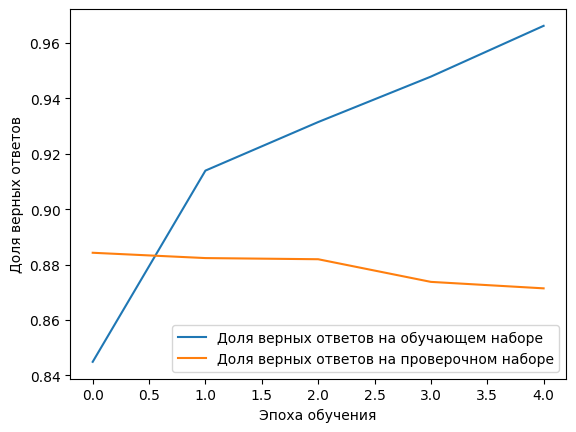

In [109]:
plt.plot(history_cnn.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть LSTM

In [110]:
model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(keras.layers.LSTM(16))
model_lstm.add(keras.layers.Dense(4, activation='softmax'))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


2025-12-01 19:13:42.798185: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:42.798239: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0


In [111]:
model_lstm.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:l

In [112]:
model_lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [113]:
# model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_filepath_lstm = '/tmp/ckpt/checkpoint.model_lstm.keras'
checkpoint_callback_lstm = ModelCheckpoint(checkpoint_filepath_lstm,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [114]:
history_lstm = model_lstm.fit(x_train,
                              y_train,
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
plica:0/task:0/device:CPU:0
identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Slice/begin: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Slice/size: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Reshape/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Slice_1/begin: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Slice_1/size: (Const): /job:localhost/replica:0/task:0/device:CPU:0
args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
args_2: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
GatherV2: (GatherV2): /job:localhost/replica:0/task:0/device:CPU:0
GatherV2_1: (GatherV2): /job:localhost/replica:0/task:0/device:CPU:0
Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Identity_1: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
identity_RetVal: (_Retva

2025-12-01 19:13:42.857034: I tensorflow/core/common_runtime/placer.cc:162] start: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:42.857077: I tensorflow/core/common_runtime/placer.cc:162] stop: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:42.857081: I tensorflow/core/common_runtime/placer.cc:162] step: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:42.857087: I tensorflow/core/common_runtime/placer.cc:162] RangeDataset: (RangeDataset): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:42.857093: I tensorflow/core/common_runtime/placer.cc:162] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:42.864724: I tensorflow/core/common_runtime/placer.cc:162] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:42.864791: I tensorflow/core/common_runtime/placer.cc:162] MapDataset: (MapDataset): /job:localhost/replica:0/task:0/device:CPU:0
2025

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


2025-12-01 19:13:43.000692: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.000740: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.013878: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.013945: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.031896: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.031967: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.042484: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


2025-12-01 19:13:43.213780: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.213839: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.227952: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.228010: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.241779: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.241838: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.255059: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/

2025-12-01 19:13:43.627858: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.627938: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_1_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.627944: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_2_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.627947: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_3_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.627949: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_4_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.627952: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_5_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:43.627954: I tensorflow/core/common_r

e:GPU:0
sequential_4/dense_6/kernel/Initializer/Cast_3/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_4/dense_6/kernel/Initializer/Cast_2/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_4/dense_6/bias/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:GPU:0
adam/sequential_4_embedding_4_embeddings_momentum/Initializer/zeros/shape_as_tensor: (Const): /job:localhost/replica:0/task:0/device:GPU:0
adam/sequential_4_embedding_4_embeddings_momentum/Initializer/zeros/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
adam/sequential_4_embedding_4_embeddings_velocity/Initializer/zeros/shape_as_tensor: (Const): /job:localhost/replica:0/task:0/device:GPU:0
adam/sequential_4_embedding_4_embeddings_velocity/Initializer/zeros/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
adam/sequential_4_lstm_1_lstm_cell_kernel_momentum/Initializer/zeros/shape_as_tensor: (Const): /job:localhost/replica:0/task:0/device:GPU:0
adam/sequ

2025-12-01 19:13:44.023031: I tensorflow/core/common_runtime/placer.cc:162] iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:13:44.023090: I tensorflow/core/common_runtime/placer.cc:162] unknown: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:44.023096: I tensorflow/core/common_runtime/placer.cc:162] unknown_0: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:44.023098: I tensorflow/core/common_runtime/placer.cc:162] unknown_1: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:44.023100: I tensorflow/core/common_runtime/placer.cc:162] unknown_2: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:44.023102: I tensorflow/core/common_runtime/placer.cc:162] unknown_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:44.023104: I tensorflow/core/common_runtime/placer.cc:162] unknown_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-12-01 19:13:44.023

Executing op __inference_multi_step_on_iterator_109057 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
  3/844 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.2422 - loss: 1.3862Executing op __inference_multi_step_on_iterator_109057 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_109057 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
  5/844 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.2555 - loss: 1.3858Executin

2025-12-01 19:14:04.133770: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:04.133815: I tensorflow/core/common_runtime/placer.cc:162] range: (Range): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:04.133820: I tensorflow/core/common_runtime/placer.cc:162] RandomShuffle: (RandomShuffle): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:04.133823: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:04.133825: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:04.133828: I tensorflow/core/common_runtime/placer.cc:162] range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:04.133830: I tensorflow/core/common_runtime/placer.cc:162] range/limit: (Const): /job:localhost/replica:0/task:0/device:C

Executing op __inference_multi_step_on_iterator_112790 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_112790 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_112790 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_112790 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:local

2025-12-01 19:14:05.697900: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:05.697942: I tensorflow/core/common_runtime/placer.cc:162] range: (Range): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:05.697947: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:05.697950: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:05.697952: I tensorflow/core/common_runtime/placer.cc:162] range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:05.697954: I tensorflow/core/common_runtime/placer.cc:162] range/limit: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:05.697956: I tensorflow/core/common_runtime/placer.cc:162] range/delta: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-

  3/844 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.8902 - loss: 0.2784Executing op __inference_multi_step_on_iterator_109057 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_109057 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_109057 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
  6/844 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8991 - loss: 0.2805Executin

2025-12-01 19:14:25.659029: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:25.659076: I tensorflow/core/common_runtime/placer.cc:162] range: (Range): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:25.659096: I tensorflow/core/common_runtime/placer.cc:162] RandomShuffle: (RandomShuffle): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:25.659102: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:25.659104: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:25.659106: I tensorflow/core/common_runtime/placer.cc:162] range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:25.659110: I tensorflow/core/common_runtime/placer.cc:162] range/limit: (Const): /job:localhost/replica:0/task:0/device:C

Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_112790 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_112790 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_112790 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/dev

2025-12-01 19:14:26.999872: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:26.999916: I tensorflow/core/common_runtime/placer.cc:162] range: (Range): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:26.999922: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:26.999925: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:26.999927: I tensorflow/core/common_runtime/placer.cc:162] range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:26.999929: I tensorflow/core/common_runtime/placer.cc:162] range/limit: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:26.999932: I tensorflow/core/common_runtime/placer.cc:162] range/delta: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-

Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
  3/844 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.9293 - loss: 0.2237Executing op __inference_multi_step_on_iterator_109057 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_109057 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_109057 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0

2025-12-01 19:14:47.159549: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:47.159589: I tensorflow/core/common_runtime/placer.cc:162] range: (Range): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:47.159594: I tensorflow/core/common_runtime/placer.cc:162] RandomShuffle: (RandomShuffle): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:47.159597: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:47.159599: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:47.159601: I tensorflow/core/common_runtime/placer.cc:162] range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:47.159604: I tensorflow/core/common_runtime/placer.cc:162] range/limit: (Const): /job:localhost/replica:0/task:0/device:C

Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_112790 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_112790 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_112790 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/dev

2025-12-01 19:14:48.506049: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:48.506097: I tensorflow/core/common_runtime/placer.cc:162] range: (Range): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:48.506102: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:48.506105: I tensorflow/core/common_runtime/placer.cc:162] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:48.506107: I tensorflow/core/common_runtime/placer.cc:162] range/start: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:48.506109: I tensorflow/core/common_runtime/placer.cc:162] range/limit: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-12-01 19:14:48.506112: I tensorflow/core/common_runtime/placer.cc:162] range/delta: (Const): /job:localhost/replica:0/task:0/device:CPU:0
2025-

Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_109057 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_multi_step_on_iterator_109057 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
  9/844 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9413 - loss: 0.2139Executing op __inference_multi_step_on_iterator_109057 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0

KeyboardInterrupt: 

In [ ]:
plt.plot(history_lstm.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть GRU

In [ ]:
model_gru = keras.Sequential()
model_gru.add(keras.layers.Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(keras.layers.GRU(16))
model_gru.add(keras.layers.Dense(4, activation='softmax'))

In [ ]:
model_gru.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_gru.summary()

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model_gru.h5`

In [ ]:
# model_gru_save_path = 'best_model_gru.h5'
checkpoint_filepath_gru = '/tmp/ckpt/checkpoint.model_gru.keras'
checkpoint_callback_gru = ModelCheckpoint(checkpoint_filepath_gru,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [ ]:
history_gru = model_gru.fit(x_train,
                              y_train,
                              epochs=10,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

In [ ]:
plt.plot(history_gru.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Загружаем набор данных для тестирования

In [ ]:
test = pd.read_csv('test.csv',
                    header=None,
                    names=['class', 'title', 'text'])

In [ ]:
test

Преобразуем новости в числовое представление

Обратите внимание, что нужно использовать токенизатор, обученный на наборе данных train.

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test['text'])

In [ ]:
x_test = pad_sequences(test_sequences, maxlen=max_news_len)

In [ ]:
x_test[:5]

Правильные ответы

In [ ]:
y_test = utils.to_categorical(test['class'] - 1, nb_classes)

In [ ]:
y_test

## Оцениваем качество работы сети на тестовом наборе данных

### Одномерная сверточная сеть

In [ ]:
model_cnn.load_weights(checkpoint_filepath_cnn)

In [ ]:
model_cnn.evaluate(x_test, y_test, verbose=1)

### Сеть LSTM

In [ ]:
model_lstm.load_weights(checkpoint_filepath_lstm)

In [ ]:
model_lstm.evaluate(x_test, y_test, verbose=1)

### Сеть GRU

In [ ]:
model_gru.load_weights(checkpoint_filepath_gru)

In [ ]:
model_gru.evaluate(x_test, y_test, verbose=1)

## Задание

1. Попробовать улучшить предсказание моделей за счет использования не только текста, но и заголовка новости.
При этом рекомендуется увеличить максимальню длину текста. <br/>
2. Проверить, как на качеаство предсказания влияет предобработка текста (удаление стоп-слов, пунктуации, лемматизация и др.)
3. Применить методы регуляризации для устранения переобучения моделей.


## Стоп-слова и пунктуация

**Стоп-слова** - это слова, которые часто встречаются практически в любом тексте и не несут полезной информации о конретном документе. Для модели это просто шум. А шум нужно убирать. По аналогичной причине убирают и пунктуацию.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
# импортируем стоп-слова из библиотеки nltk
from nltk.corpus import stopwords

# посмотрим на стоп-слова для английского языка
print(len(stopwords.words('english')))

*Знаки* пунктуации лучше импортировать из модуля **String**. В нем хранятся различные наборы констант для работы со строками (пунктуация, алфавит и др.).

In [ ]:
from string import punctuation
punctuation



Объединим стоп-слова и знаки пунктуации вместе и запишем в переменную noise:


In [ ]:
noise = stopwords.words('english') + list(punctuation)


## Лемматизация

**Лемматизация** – это сведение разных форм одного слова к начальной форме – **лемме**. Почему это хорошо?
* Во-первых, естественно рассматривать как отдельный признак каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
news = list(lemmatizer.lemmatize(word) for word in news)

## Полезные ссылки

1. [Как понять LSTM сети](https://alexsosn.github.io/ml/2015/11/17/LSTM.html)
2. [Рекуррентные нейронные сети в Keras](https://keras.io/layers/recurrent/)
3. [Регуляризуем правильно!](https://telegra.ph/Regulyarizuem-pravilno-09-20)
4. [12 основных методов Dropout](https://towardsdatascience.com/12-main-dropout-methods-mathematical-and-visual-explanation-58cdc2112293?source=topic_page---------6------------------1)

In [ ]:
from keras.src.callbacks import EarlyStopping
from typing import Dict, List, Literal, Any

df_train = pd.read_csv('train.csv', header=None, names=['class', 'title', 'text'])
df_test = pd.read_csv('test.csv', header=None, names=['class', 'title', 'text'])
classes = { i+1: line for i, line in enumerate(open('classes.txt').read().split('\n')) if line }
classes

In [ ]:
# nltk resources
_stopwords = set(stopwords.words('english'))
_punctuation = set(punctuation)
_noise = _stopwords | _punctuation
_lemmatizer = WordNetLemmatizer()

_NON_ALPHANUMERIC_REGEX = re.compile(r'[^a-zA-Z0-9\s]+')

def preprocess_text(text: str) -> str:
    text = str(text).lower()
    text = _NON_ALPHANUMERIC_REGEX.sub(' ', text)
    tokens = text.split()
    clean_tokens = [_lemmatizer.lemmatize(tok) for tok in tokens if tok not in _noise]
    return ' '.join(clean_tokens)

preprocess_text("So eat more of these soft french buns, and drink some tea")

In [ ]:
from sklearn.metrics import f1_score


def run_experiment(
        experiment_name: str = "experiment",
        nn_type: Literal["cnn", "lstm", "gru"] = "cnn",
        do_dropout: bool = False,
        do_early_stopping: bool = False,
        max_news_len: int = 30,
        do_add_header: bool = False,
        do_preprocess_text: bool = False,
        epochs: int = 5,
        batch_size: int = 128,
        validation_split: float = 0.1,
) -> Dict[str, Any]:
    """
    Generalized experiment runner matching the original notebook's setup.

    Parameters:
        experiment_name    : used in checkpoint filename.
        nn_type            : "cnn" / "lstm" / "gru".
        do_dropout         : add Dropout layer(s) after pooling/recurrent layer.
        do_early_stopping  : use EarlyStopping callback.
        max_news_len       : pad_sequences length.
        do_add_header      : if True, use title + ' ' + text as input.
        do_preprocess_text : if True, apply preprocess_text() to each sample.
        epochs             : max epochs to train.
        batch_size         : batch size.
        validation_split   : fraction of train data for validation.

    Returns:
        Dict with experiment config and metrics (test accuracy, macro-F1).
    """

    print(f"\n=== {experiment_name} | nn_type={nn_type} ===")
    print(f"  do_dropout={do_dropout}, do_early_stopping={do_early_stopping}, "
          f"max_news_len={max_news_len}, do_add_header={do_add_header}, "
          f"do_preprocess_text={do_preprocess_text}")

    # ----- 1. Build raw texts exactly as in the notebook -----
    if do_add_header:
        # i.e. news = train['title'] + ' ' + train['text']
        train_texts_raw = (df_train['title'].astype(str) + ' ' + df_train['text'].astype(str)).tolist()
        test_texts_raw = (df_test['title'].astype(str) + ' ' + df_test['text'].astype(str)).tolist()
    else:
        # i.e. news = train['text']
        train_texts_raw = df_train['text'].astype(str).tolist()
        test_texts_raw = df_test['text'].astype(str).tolist()

    if do_preprocess_text:
        train_texts = [preprocess_text(t) for t in train_texts_raw]
        test_texts = [preprocess_text(t) for t in test_texts_raw]
    else:
        train_texts = train_texts_raw
        test_texts = test_texts_raw

    # ----- 2. Labels as in notebook -----
    # y_train = utils.to_categorical(train['class'] - 1, nb_classes)
    y_train = utils.to_categorical(df_train['class'].values.astype(int) - 1, nb_classes)
    y_test = utils.to_categorical(df_test['class'].values.astype(int) - 1, nb_classes)

    # ----- 3. Tokenize (same Tokenizer usage as in notebook) -----
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(train_texts)

    sequences_train = tokenizer.texts_to_sequences(train_texts)
    sequences_test = tokenizer.texts_to_sequences(test_texts)

    x_train = pad_sequences(sequences_train, maxlen=max_news_len)
    x_test = pad_sequences(sequences_test, maxlen=max_news_len)

    print(f"  x_train shape = {x_train.shape}, x_test shape = {x_test.shape}")

    # ----- 4. Build model as in notebook -----
    model = Sequential()
    model.add(layers.Embedding(num_words, 32, input_length=max_news_len))

    if nn_type == "cnn":
        # CNN architecture from the notebook
        model.add(layers.Conv1D(250, 5, padding='valid', activation='relu'))
        model.add(layers.GlobalMaxPooling1D())
        if do_dropout:
            model.add(layers.Dropout(0.3))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(nb_classes, activation='softmax'))

    elif nn_type == "lstm":
        model.add(layers.LSTM(16))
        if do_dropout:
            model.add(layers.Dropout(0.3))
        model.add(layers.Dense(nb_classes, activation='softmax'))

    elif nn_type == "gru":
        model.add(layers.GRU(16))
        if do_dropout:
            model.add(layers.Dropout(0.3))
        model.add(layers.Dense(nb_classes, activation='softmax'))

    else:
        raise ValueError(f"Unknown nn_type: {nn_type}")

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # model.summary()



    # ----- 5. Callbacks: ModelCheckpoint + optional EarlyStopping -----
    callbacks = []

    os.makedirs("/tmp/ckpt", exist_ok=True)
    checkpoint_filepath = f"/tmp/ckpt/checkpoint.{experiment_name}.{nn_type}.keras"
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        save_weights_only=True
    )
    callbacks.append(checkpoint_callback)

    if do_early_stopping:
        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )
        callbacks.append(early_stopping)

    # ----- 6. Training (as in CNN/LSTM/GRU fit with validation_split=0.1) -----
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=callbacks,
        verbose=1
    )

    # Reload best weights if checkpoint exists
    if os.path.exists(checkpoint_filepath):
        model.load_weights(checkpoint_filepath)

    # ----- 7. Evaluation on test -----
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    y_test_pred_probs = model.predict(x_test, verbose=0)
    y_test_true = df_test['class'].values.astype(int) - 1
    y_test_pred = np.argmax(y_test_pred_probs, axis=1)
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    print(f"[{experiment_name} / {nn_type}] "
          f"Test accuracy = {test_accuracy:.4f}, macro-F1 = {test_f1:.4f}")

    return {
        "experiment_name": experiment_name,
        "nn_type": nn_type,
        "do_dropout": do_dropout,
        "do_early_stopping": do_early_stopping,
        "max_news_len": max_news_len,
        "do_add_header": do_add_header,
        "do_preprocess_text": do_preprocess_text,
        "test_accuracy": float(test_accuracy),
        "test_f1": float(test_f1),
        "history": history.history,
    }
